### 라이브러리 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time


device = torch.device('cuda')

In [1]:
!nvidia-smi

Mon Apr 18 12:48:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:00:06.0 Off |                  Off |
| N/A   31C    P0    35W / 250W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:00:07.0 Off |                  Off |
| N/A   

In [24]:
torch.save(model.state_dict(), "./Daicon/daicon_model.pt")

In [22]:
pwd

'/home/ubuntu'

In [4]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
train_png = sorted(glob('./Daicon/청경채/train/*.png'))
test_png = sorted(glob('./Daicon/청경채/test/*.png'))

In [3]:
train_y = pd.read_csv("./Daicon/청경채/open/train_df.csv")

train_labels = train_y["label"]

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]

In [4]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]    
    img = cv2.resize(img, (512, 512))
    return img

In [5]:
train_imgs = [img_load(m) for m in tqdm(train_png)]
test_imgs = [img_load(n) for n in tqdm(test_png)]

0it [00:00, ?it/s]
100%|██████████| 2154/2154 [01:03<00:00, 33.94it/s]


In [8]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            augmentation = random.randint(0,2)
            if augmentation==1:
                img = img[::-1].copy()
            elif augmentation==2:
                img = img[:,::-1].copy()
        img = transforms.ToTensor()(img)
        if self.mode=='test':
            pass
        
        label = self.labels[idx]
        return img, label
    
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('resnetv2_50', pretrained=True, num_classes=88)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [6]:
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models), avail_pretrained_models[:5]

(592,
 ['adv_inception_v3',
  'bat_resnext26ts',
  'beit_base_patch16_224',
  'beit_base_patch16_224_in22k',
  'beit_base_patch16_384'])

In [7]:
all_densenet_models = timm.list_models('*resnet*')
all_densenet_models

['cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'eca_resnet33ts',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'ens_adv_inception_resnet_v2',
 'gcresnet33ts',
 'gcresnet50t',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resnet50_v1s',
 'gluon_resnet101_v1b',
 'gluon_resnet101_v1c',
 'gluon_resnet101_v1d',
 'gluon_resnet101_v1s',
 'gluon_resnet152_v1b',
 'gluon_resnet152_v1c',
 'gluon_resnet152_v1d',
 'gluon_resnet152_v1s',
 'inception_resnet_v2',
 'lambda_resnet26rpt_256',
 'lambda_resnet26t',
 'lambda_resnet50ts',
 'legacy_seresnet18',
 'legacy_seresnet34',
 'legacy_seresnet50',
 'legacy_seresnet101',
 'legacy_seresnet152',
 'nf_ecaresnet26',
 'nf_ecaresnet50',
 'nf_ecaresnet101',
 'nf_resnet26',
 'nf_resnet50',
 'nf_resnet101',
 'nf_seresnet26',
 'nf_seresnet50',
 'nf_seresnet1

In [9]:
batch_size = 32
epochs = 50

# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

ValueError: num_samples should be a positive integer value, but got num_samples=0

### 모델 학습

In [27]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 



best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

epoch : 1/50    time : 54s/2664s
TRAIN    loss : 1.26774    f1 : 0.15133
epoch : 2/50    time : 55s/2625s
TRAIN    loss : 0.63887    f1 : 0.19834
epoch : 3/50    time : 54s/2549s
TRAIN    loss : 0.53374    f1 : 0.32605
epoch : 4/50    time : 55s/2511s
TRAIN    loss : 0.48336    f1 : 0.35948
epoch : 5/50    time : 55s/2454s
TRAIN    loss : 0.39757    f1 : 0.44306
epoch : 6/50    time : 54s/2388s
TRAIN    loss : 0.35005    f1 : 0.51023
epoch : 7/50    time : 55s/2357s
TRAIN    loss : 0.28511    f1 : 0.59631
epoch : 8/50    time : 54s/2278s
TRAIN    loss : 0.24045    f1 : 0.65198
epoch : 9/50    time : 55s/2246s
TRAIN    loss : 0.24056    f1 : 0.67063
epoch : 10/50    time : 54s/2168s
TRAIN    loss : 0.21584    f1 : 0.70586
epoch : 11/50    time : 55s/2129s
TRAIN    loss : 0.17533    f1 : 0.76205
epoch : 12/50    time : 55s/2072s
TRAIN    loss : 0.16411    f1 : 0.77052
epoch : 13/50    time : 54s/2008s
TRAIN    loss : 0.11916    f1 : 0.83317
epoch : 14/50    time : 55s/1978s
TRAIN    loss

### 추론

In [15]:
model.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

In [16]:
label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

### 제출물 생성

In [17]:
submission = pd.read_csv("./Daicon/청경채/open/sample_submission.csv")

submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-good
3,3,tile-gray_stroke
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-good


In [18]:
submission.to_csv("daicon.csv", index = False)

In [2]:
!unzip open.zip -d ./dacon_data

Archive:  open.zip
  inflating: ./dacon_data/open/sample_submission.csv  
 extracting: ./dacon_data/open/test.zip  
  inflating: ./dacon_data/open/test_df.csv  
 extracting: ./dacon_data/open/train.zip  
  inflating: ./dacon_data/open/train_df.csv  


In [3]:
pwd

'/home/ubuntu'

In [4]:
cd dacon_data/open

/home/ubuntu/dacon_data/open


In [7]:
!unzip test.zip 

Archive:  test.zip
  inflating: test/20000.png          
  inflating: test/20001.png          
  inflating: test/20002.png          
  inflating: test/20003.png          
  inflating: test/20004.png          
  inflating: test/20005.png          
  inflating: test/20006.png          
  inflating: test/20007.png          
  inflating: test/20008.png          
  inflating: test/20009.png          
  inflating: test/20010.png          
  inflating: test/20011.png          
  inflating: test/20012.png          
  inflating: test/20013.png          
  inflating: test/20014.png          
  inflating: test/20015.png          
  inflating: test/20016.png          
  inflating: test/20017.png          
  inflating: test/20018.png          
  inflating: test/20019.png          
  inflating: test/20020.png          
  inflating: test/20021.png          
  inflating: test/20022.png          
  inflating: test/20023.png          
  inflating: test/20024.png          
  inflating: test/20025.png    

  inflating: test/20221.png          
  inflating: test/20222.png          
  inflating: test/20223.png          
  inflating: test/20224.png          
  inflating: test/20225.png          
  inflating: test/20226.png          
  inflating: test/20227.png          
  inflating: test/20228.png          
  inflating: test/20229.png          
  inflating: test/20230.png          
  inflating: test/20231.png          
  inflating: test/20232.png          
  inflating: test/20233.png          
  inflating: test/20234.png          
  inflating: test/20235.png          
  inflating: test/20236.png          
  inflating: test/20237.png          
  inflating: test/20238.png          
  inflating: test/20239.png          
  inflating: test/20240.png          
  inflating: test/20241.png          
  inflating: test/20242.png          
  inflating: test/20243.png          
  inflating: test/20244.png          
  inflating: test/20245.png          
  inflating: test/20246.png          
  inflating:

  inflating: test/20439.png          
  inflating: test/20440.png          
  inflating: test/20441.png          
  inflating: test/20442.png          
  inflating: test/20443.png          
  inflating: test/20444.png          
  inflating: test/20445.png          
  inflating: test/20446.png          
  inflating: test/20447.png          
  inflating: test/20448.png          
  inflating: test/20449.png          
  inflating: test/20450.png          
  inflating: test/20451.png          
  inflating: test/20452.png          
  inflating: test/20453.png          
  inflating: test/20454.png          
  inflating: test/20455.png          
  inflating: test/20456.png          
  inflating: test/20457.png          
  inflating: test/20458.png          
  inflating: test/20459.png          
  inflating: test/20460.png          
  inflating: test/20461.png          
  inflating: test/20462.png          
  inflating: test/20463.png          
  inflating: test/20464.png          
  inflating:

  inflating: test/20660.png          
  inflating: test/20661.png          
  inflating: test/20662.png          
  inflating: test/20663.png          
  inflating: test/20664.png          
  inflating: test/20665.png          
  inflating: test/20666.png          
  inflating: test/20667.png          
  inflating: test/20668.png          
  inflating: test/20669.png          
  inflating: test/20670.png          
  inflating: test/20671.png          
  inflating: test/20672.png          
  inflating: test/20673.png          
  inflating: test/20674.png          
  inflating: test/20675.png          
  inflating: test/20676.png          
  inflating: test/20677.png          
  inflating: test/20678.png          
  inflating: test/20679.png          
  inflating: test/20680.png          
  inflating: test/20681.png          
  inflating: test/20682.png          
  inflating: test/20683.png          
  inflating: test/20684.png          
  inflating: test/20685.png          
  inflating:

  inflating: test/20875.png          
  inflating: test/20876.png          
  inflating: test/20877.png          
  inflating: test/20878.png          
  inflating: test/20879.png          
  inflating: test/20880.png          
  inflating: test/20881.png          
  inflating: test/20882.png          
  inflating: test/20883.png          
  inflating: test/20884.png          
  inflating: test/20885.png          
  inflating: test/20886.png          
  inflating: test/20887.png          
  inflating: test/20888.png          
  inflating: test/20889.png          
  inflating: test/20890.png          
  inflating: test/20891.png          
  inflating: test/20892.png          
  inflating: test/20893.png          
  inflating: test/20894.png          
  inflating: test/20895.png          
  inflating: test/20896.png          
  inflating: test/20897.png          
  inflating: test/20898.png          
  inflating: test/20899.png          
  inflating: test/20900.png          
  inflating:

  inflating: test/21091.png          
  inflating: test/21092.png          
  inflating: test/21093.png          
  inflating: test/21094.png          
  inflating: test/21095.png          
  inflating: test/21096.png          
  inflating: test/21097.png          
  inflating: test/21098.png          
  inflating: test/21099.png          
  inflating: test/21100.png          
  inflating: test/21101.png          
  inflating: test/21102.png          
  inflating: test/21103.png          
  inflating: test/21104.png          
  inflating: test/21105.png          
  inflating: test/21106.png          
  inflating: test/21107.png          
  inflating: test/21108.png          
  inflating: test/21109.png          
  inflating: test/21110.png          
  inflating: test/21111.png          
  inflating: test/21112.png          
  inflating: test/21113.png          
  inflating: test/21114.png          
  inflating: test/21115.png          
  inflating: test/21116.png          
  inflating:

  inflating: test/21308.png          
  inflating: test/21309.png          
  inflating: test/21310.png          
  inflating: test/21311.png          
  inflating: test/21312.png          
  inflating: test/21313.png          
  inflating: test/21314.png          
  inflating: test/21315.png          
  inflating: test/21316.png          
  inflating: test/21317.png          
  inflating: test/21318.png          
  inflating: test/21319.png          
  inflating: test/21320.png          
  inflating: test/21321.png          
  inflating: test/21322.png          
  inflating: test/21323.png          
  inflating: test/21324.png          
  inflating: test/21325.png          
  inflating: test/21326.png          
  inflating: test/21327.png          
  inflating: test/21328.png          
  inflating: test/21329.png          
  inflating: test/21330.png          
  inflating: test/21331.png          
  inflating: test/21332.png          
  inflating: test/21333.png          
  inflating:

  inflating: test/21523.png          
  inflating: test/21524.png          
  inflating: test/21525.png          
  inflating: test/21526.png          
  inflating: test/21527.png          
  inflating: test/21528.png          
  inflating: test/21529.png          
  inflating: test/21530.png          
  inflating: test/21531.png          
  inflating: test/21532.png          
  inflating: test/21533.png          
  inflating: test/21534.png          
  inflating: test/21535.png          
  inflating: test/21536.png          
  inflating: test/21537.png          
  inflating: test/21538.png          
  inflating: test/21539.png          
  inflating: test/21540.png          
  inflating: test/21541.png          
  inflating: test/21542.png          
  inflating: test/21543.png          
  inflating: test/21544.png          
  inflating: test/21545.png          
  inflating: test/21546.png          
  inflating: test/21547.png          
  inflating: test/21548.png          
  inflating:

  inflating: test/21744.png          
  inflating: test/21745.png          
  inflating: test/21746.png          
  inflating: test/21747.png          
  inflating: test/21748.png          
  inflating: test/21749.png          
  inflating: test/21750.png          
  inflating: test/21751.png          
  inflating: test/21752.png          
  inflating: test/21753.png          
  inflating: test/21754.png          
  inflating: test/21755.png          
  inflating: test/21756.png          
  inflating: test/21757.png          
  inflating: test/21758.png          
  inflating: test/21759.png          
  inflating: test/21760.png          
  inflating: test/21761.png          
  inflating: test/21762.png          
  inflating: test/21763.png          
  inflating: test/21764.png          
  inflating: test/21765.png          
  inflating: test/21766.png          
  inflating: test/21767.png          
  inflating: test/21768.png          
  inflating: test/21769.png          
  inflating:

  inflating: test/21962.png          
  inflating: test/21963.png          
  inflating: test/21964.png          
  inflating: test/21965.png          
  inflating: test/21966.png          
  inflating: test/21967.png          
  inflating: test/21968.png          
  inflating: test/21969.png          
  inflating: test/21970.png          
  inflating: test/21971.png          
  inflating: test/21972.png          
  inflating: test/21973.png          
  inflating: test/21974.png          
  inflating: test/21975.png          
  inflating: test/21976.png          
  inflating: test/21977.png          
  inflating: test/21978.png          
  inflating: test/21979.png          
  inflating: test/21980.png          
  inflating: test/21981.png          
  inflating: test/21982.png          
  inflating: test/21983.png          
  inflating: test/21984.png          
  inflating: test/21985.png          
  inflating: test/21986.png          
  inflating: test/21987.png          
  inflating:

In [6]:
!unzip train.zip 

Archive:  train.zip
  inflating: train/10000.png         
  inflating: train/10001.png         
  inflating: train/10002.png         
  inflating: train/10003.png         
  inflating: train/10004.png         
  inflating: train/10005.png         
  inflating: train/10006.png         
  inflating: train/10007.png         
  inflating: train/10008.png         
  inflating: train/10009.png         
  inflating: train/10010.png         
  inflating: train/10011.png         
  inflating: train/10012.png         
  inflating: train/10013.png         
  inflating: train/10014.png         
  inflating: train/10015.png         
  inflating: train/10016.png         
  inflating: train/10017.png         
  inflating: train/10018.png         
  inflating: train/10019.png         
  inflating: train/10020.png         
  inflating: train/10021.png         
  inflating: train/10022.png         
  inflating: train/10023.png         
  inflating: train/10024.png         
  inflating: train/10025.png  

  inflating: train/10219.png         
  inflating: train/10220.png         
  inflating: train/10221.png         
  inflating: train/10222.png         
  inflating: train/10223.png         
  inflating: train/10224.png         
  inflating: train/10225.png         
  inflating: train/10226.png         
  inflating: train/10227.png         
  inflating: train/10228.png         
  inflating: train/10229.png         
  inflating: train/10230.png         
  inflating: train/10231.png         
  inflating: train/10232.png         
  inflating: train/10233.png         
  inflating: train/10234.png         
  inflating: train/10235.png         
  inflating: train/10236.png         
  inflating: train/10237.png         
  inflating: train/10238.png         
  inflating: train/10239.png         
  inflating: train/10240.png         
  inflating: train/10241.png         
  inflating: train/10242.png         
  inflating: train/10243.png         
  inflating: train/10244.png         
  inflating:

  inflating: train/10435.png         
  inflating: train/10436.png         
  inflating: train/10437.png         
  inflating: train/10438.png         
  inflating: train/10439.png         
  inflating: train/10440.png         
  inflating: train/10441.png         
  inflating: train/10442.png         
  inflating: train/10443.png         
  inflating: train/10444.png         
  inflating: train/10445.png         
  inflating: train/10446.png         
  inflating: train/10447.png         
  inflating: train/10448.png         
  inflating: train/10449.png         
  inflating: train/10450.png         
  inflating: train/10451.png         
  inflating: train/10452.png         
  inflating: train/10453.png         
  inflating: train/10454.png         
  inflating: train/10455.png         
  inflating: train/10456.png         
  inflating: train/10457.png         
  inflating: train/10458.png         
  inflating: train/10459.png         
  inflating: train/10460.png         
  inflating:

  inflating: train/10655.png         
  inflating: train/10656.png         
  inflating: train/10657.png         
  inflating: train/10658.png         
  inflating: train/10659.png         
  inflating: train/10660.png         
  inflating: train/10661.png         
  inflating: train/10662.png         
  inflating: train/10663.png         
  inflating: train/10664.png         
  inflating: train/10665.png         
  inflating: train/10666.png         
  inflating: train/10667.png         
  inflating: train/10668.png         
  inflating: train/10669.png         
  inflating: train/10670.png         
  inflating: train/10671.png         
  inflating: train/10672.png         
  inflating: train/10673.png         
  inflating: train/10674.png         
  inflating: train/10675.png         
  inflating: train/10676.png         
  inflating: train/10677.png         
  inflating: train/10678.png         
  inflating: train/10679.png         
  inflating: train/10680.png         
  inflating:

  inflating: train/10874.png         
  inflating: train/10875.png         
  inflating: train/10876.png         
  inflating: train/10877.png         
  inflating: train/10878.png         
  inflating: train/10879.png         
  inflating: train/10880.png         
  inflating: train/10881.png         
  inflating: train/10882.png         
  inflating: train/10883.png         
  inflating: train/10884.png         
  inflating: train/10885.png         
  inflating: train/10886.png         
  inflating: train/10887.png         
  inflating: train/10888.png         
  inflating: train/10889.png         
  inflating: train/10890.png         
  inflating: train/10891.png         
  inflating: train/10892.png         
  inflating: train/10893.png         
  inflating: train/10894.png         
  inflating: train/10895.png         
  inflating: train/10896.png         
  inflating: train/10897.png         
  inflating: train/10898.png         
  inflating: train/10899.png         
  inflating:

  inflating: train/11089.png         
  inflating: train/11090.png         
  inflating: train/11091.png         
  inflating: train/11092.png         
  inflating: train/11093.png         
  inflating: train/11094.png         
  inflating: train/11095.png         
  inflating: train/11096.png         
  inflating: train/11097.png         
  inflating: train/11098.png         
  inflating: train/11099.png         
  inflating: train/11100.png         
  inflating: train/11101.png         
  inflating: train/11102.png         
  inflating: train/11103.png         
  inflating: train/11104.png         
  inflating: train/11105.png         
  inflating: train/11106.png         
  inflating: train/11107.png         
  inflating: train/11108.png         
  inflating: train/11109.png         
  inflating: train/11110.png         
  inflating: train/11111.png         
  inflating: train/11112.png         
  inflating: train/11113.png         
  inflating: train/11114.png         
  inflating:

  inflating: train/11312.png         
  inflating: train/11313.png         
  inflating: train/11314.png         
  inflating: train/11315.png         
  inflating: train/11316.png         
  inflating: train/11317.png         
  inflating: train/11318.png         
  inflating: train/11319.png         
  inflating: train/11320.png         
  inflating: train/11321.png         
  inflating: train/11322.png         
  inflating: train/11323.png         
  inflating: train/11324.png         
  inflating: train/11325.png         
  inflating: train/11326.png         
  inflating: train/11327.png         
  inflating: train/11328.png         
  inflating: train/11329.png         
  inflating: train/11330.png         
  inflating: train/11331.png         
  inflating: train/11332.png         
  inflating: train/11333.png         
  inflating: train/11334.png         
  inflating: train/11335.png         
  inflating: train/11336.png         
  inflating: train/11337.png         
  inflating:

  inflating: train/11529.png         
  inflating: train/11530.png         
  inflating: train/11531.png         
  inflating: train/11532.png         
  inflating: train/11533.png         
  inflating: train/11534.png         
  inflating: train/11535.png         
  inflating: train/11536.png         
  inflating: train/11537.png         
  inflating: train/11538.png         
  inflating: train/11539.png         
  inflating: train/11540.png         
  inflating: train/11541.png         
  inflating: train/11542.png         
  inflating: train/11543.png         
  inflating: train/11544.png         
  inflating: train/11545.png         
  inflating: train/11546.png         
  inflating: train/11547.png         
  inflating: train/11548.png         
  inflating: train/11549.png         
  inflating: train/11550.png         
  inflating: train/11551.png         
  inflating: train/11552.png         
  inflating: train/11553.png         
  inflating: train/11554.png         
  inflating:

  inflating: train/11749.png         
  inflating: train/11750.png         
  inflating: train/11751.png         
  inflating: train/11752.png         
  inflating: train/11753.png         
  inflating: train/11754.png         
  inflating: train/11755.png         
  inflating: train/11756.png         
  inflating: train/11757.png         
  inflating: train/11758.png         
  inflating: train/11759.png         
  inflating: train/11760.png         
  inflating: train/11761.png         
  inflating: train/11762.png         
  inflating: train/11763.png         
  inflating: train/11764.png         
  inflating: train/11765.png         
  inflating: train/11766.png         
  inflating: train/11767.png         
  inflating: train/11768.png         
  inflating: train/11769.png         
  inflating: train/11770.png         
  inflating: train/11771.png         
  inflating: train/11772.png         
  inflating: train/11773.png         
  inflating: train/11774.png         
  inflating:

  inflating: train/11967.png         
  inflating: train/11968.png         
  inflating: train/11969.png         
  inflating: train/11970.png         
  inflating: train/11971.png         
  inflating: train/11972.png         
  inflating: train/11973.png         
  inflating: train/11974.png         
  inflating: train/11975.png         
  inflating: train/11976.png         
  inflating: train/11977.png         
  inflating: train/11978.png         
  inflating: train/11979.png         
  inflating: train/11980.png         
  inflating: train/11981.png         
  inflating: train/11982.png         
  inflating: train/11983.png         
  inflating: train/11984.png         
  inflating: train/11985.png         
  inflating: train/11986.png         
  inflating: train/11987.png         
  inflating: train/11988.png         
  inflating: train/11989.png         
  inflating: train/11990.png         
  inflating: train/11991.png         
  inflating: train/11992.png         
  inflating:

  inflating: train/12186.png         
  inflating: train/12187.png         
  inflating: train/12188.png         
  inflating: train/12189.png         
  inflating: train/12190.png         
  inflating: train/12191.png         
  inflating: train/12192.png         
  inflating: train/12193.png         
  inflating: train/12194.png         
  inflating: train/12195.png         
  inflating: train/12196.png         
  inflating: train/12197.png         
  inflating: train/12198.png         
  inflating: train/12199.png         
  inflating: train/12200.png         
  inflating: train/12201.png         
  inflating: train/12202.png         
  inflating: train/12203.png         
  inflating: train/12204.png         
  inflating: train/12205.png         
  inflating: train/12206.png         
  inflating: train/12207.png         
  inflating: train/12208.png         
  inflating: train/12209.png         
  inflating: train/12210.png         
  inflating: train/12211.png         
  inflating:

  inflating: train/12407.png         
  inflating: train/12408.png         
  inflating: train/12409.png         
  inflating: train/12410.png         
  inflating: train/12411.png         
  inflating: train/12412.png         
  inflating: train/12413.png         
  inflating: train/12414.png         
  inflating: train/12415.png         
  inflating: train/12416.png         
  inflating: train/12417.png         
  inflating: train/12418.png         
  inflating: train/12419.png         
  inflating: train/12420.png         
  inflating: train/12421.png         
  inflating: train/12422.png         
  inflating: train/12423.png         
  inflating: train/12424.png         
  inflating: train/12425.png         
  inflating: train/12426.png         
  inflating: train/12427.png         
  inflating: train/12428.png         
  inflating: train/12429.png         
  inflating: train/12430.png         
  inflating: train/12431.png         
  inflating: train/12432.png         
  inflating:

  inflating: train/12622.png         
  inflating: train/12623.png         
  inflating: train/12624.png         
  inflating: train/12625.png         
  inflating: train/12626.png         
  inflating: train/12627.png         
  inflating: train/12628.png         
  inflating: train/12629.png         
  inflating: train/12630.png         
  inflating: train/12631.png         
  inflating: train/12632.png         
  inflating: train/12633.png         
  inflating: train/12634.png         
  inflating: train/12635.png         
  inflating: train/12636.png         
  inflating: train/12637.png         
  inflating: train/12638.png         
  inflating: train/12639.png         
  inflating: train/12640.png         
  inflating: train/12641.png         
  inflating: train/12642.png         
  inflating: train/12643.png         
  inflating: train/12644.png         
  inflating: train/12645.png         
  inflating: train/12646.png         
  inflating: train/12647.png         
  inflating:

  inflating: train/12843.png         
  inflating: train/12844.png         
  inflating: train/12845.png         
  inflating: train/12846.png         
  inflating: train/12847.png         
  inflating: train/12848.png         
  inflating: train/12849.png         
  inflating: train/12850.png         
  inflating: train/12851.png         
  inflating: train/12852.png         
  inflating: train/12853.png         
  inflating: train/12854.png         
  inflating: train/12855.png         
  inflating: train/12856.png         
  inflating: train/12857.png         
  inflating: train/12858.png         
  inflating: train/12859.png         
  inflating: train/12860.png         
  inflating: train/12861.png         
  inflating: train/12862.png         
  inflating: train/12863.png         
  inflating: train/12864.png         
  inflating: train/12865.png         
  inflating: train/12866.png         
  inflating: train/12867.png         
  inflating: train/12868.png         
  inflating:

  inflating: train/13062.png         
  inflating: train/13063.png         
  inflating: train/13064.png         
  inflating: train/13065.png         
  inflating: train/13066.png         
  inflating: train/13067.png         
  inflating: train/13068.png         
  inflating: train/13069.png         
  inflating: train/13070.png         
  inflating: train/13071.png         
  inflating: train/13072.png         
  inflating: train/13073.png         
  inflating: train/13074.png         
  inflating: train/13075.png         
  inflating: train/13076.png         
  inflating: train/13077.png         
  inflating: train/13078.png         
  inflating: train/13079.png         
  inflating: train/13080.png         
  inflating: train/13081.png         
  inflating: train/13082.png         
  inflating: train/13083.png         
  inflating: train/13084.png         
  inflating: train/13085.png         
  inflating: train/13086.png         
  inflating: train/13087.png         
  inflating:

  inflating: train/13277.png         
  inflating: train/13278.png         
  inflating: train/13279.png         
  inflating: train/13280.png         
  inflating: train/13281.png         
  inflating: train/13282.png         
  inflating: train/13283.png         
  inflating: train/13284.png         
  inflating: train/13285.png         
  inflating: train/13286.png         
  inflating: train/13287.png         
  inflating: train/13288.png         
  inflating: train/13289.png         
  inflating: train/13290.png         
  inflating: train/13291.png         
  inflating: train/13292.png         
  inflating: train/13293.png         
  inflating: train/13294.png         
  inflating: train/13295.png         
  inflating: train/13296.png         
  inflating: train/13297.png         
  inflating: train/13298.png         
  inflating: train/13299.png         
  inflating: train/13300.png         
  inflating: train/13301.png         
  inflating: train/13302.png         
  inflating:

  inflating: train/13492.png         
  inflating: train/13493.png         
  inflating: train/13494.png         
  inflating: train/13495.png         
  inflating: train/13496.png         
  inflating: train/13497.png         
  inflating: train/13498.png         
  inflating: train/13499.png         
  inflating: train/13500.png         
  inflating: train/13501.png         
  inflating: train/13502.png         
  inflating: train/13503.png         
  inflating: train/13504.png         
  inflating: train/13505.png         
  inflating: train/13506.png         
  inflating: train/13507.png         
  inflating: train/13508.png         
  inflating: train/13509.png         
  inflating: train/13510.png         
  inflating: train/13511.png         
  inflating: train/13512.png         
  inflating: train/13513.png         
  inflating: train/13514.png         
  inflating: train/13515.png         
  inflating: train/13516.png         
  inflating: train/13517.png         
  inflating:

  inflating: train/13711.png         
  inflating: train/13712.png         
  inflating: train/13713.png         
  inflating: train/13714.png         
  inflating: train/13715.png         
  inflating: train/13716.png         
  inflating: train/13717.png         
  inflating: train/13718.png         
  inflating: train/13719.png         
  inflating: train/13720.png         
  inflating: train/13721.png         
  inflating: train/13722.png         
  inflating: train/13723.png         
  inflating: train/13724.png         
  inflating: train/13725.png         
  inflating: train/13726.png         
  inflating: train/13727.png         
  inflating: train/13728.png         
  inflating: train/13729.png         
  inflating: train/13730.png         
  inflating: train/13731.png         
  inflating: train/13732.png         
  inflating: train/13733.png         
  inflating: train/13734.png         
  inflating: train/13735.png         
  inflating: train/13736.png         
  inflating:

  inflating: train/13930.png         
  inflating: train/13931.png         
  inflating: train/13932.png         
  inflating: train/13933.png         
  inflating: train/13934.png         
  inflating: train/13935.png         
  inflating: train/13936.png         
  inflating: train/13937.png         
  inflating: train/13938.png         
  inflating: train/13939.png         
  inflating: train/13940.png         
  inflating: train/13941.png         
  inflating: train/13942.png         
  inflating: train/13943.png         
  inflating: train/13944.png         
  inflating: train/13945.png         
  inflating: train/13946.png         
  inflating: train/13947.png         
  inflating: train/13948.png         
  inflating: train/13949.png         
  inflating: train/13950.png         
  inflating: train/13951.png         
  inflating: train/13952.png         
  inflating: train/13953.png         
  inflating: train/13954.png         
  inflating: train/13955.png         
  inflating:

  inflating: train/14148.png         
  inflating: train/14149.png         
  inflating: train/14150.png         
  inflating: train/14151.png         
  inflating: train/14152.png         
  inflating: train/14153.png         
  inflating: train/14154.png         
  inflating: train/14155.png         
  inflating: train/14156.png         
  inflating: train/14157.png         
  inflating: train/14158.png         
  inflating: train/14159.png         
  inflating: train/14160.png         
  inflating: train/14161.png         
  inflating: train/14162.png         
  inflating: train/14163.png         
  inflating: train/14164.png         
  inflating: train/14165.png         
  inflating: train/14166.png         
  inflating: train/14167.png         
  inflating: train/14168.png         
  inflating: train/14169.png         
  inflating: train/14170.png         
  inflating: train/14171.png         
  inflating: train/14172.png         
  inflating: train/14173.png         
  inflating:

In [8]:
import pandas as pd

train_df = pd.read_csv("train_df.csv")
print(len(train_df["label"].unique()))  # type = numpy.array
label_list = train_df["label"].unique().tolist()
len(label_list)  # type = list

88


88

In [9]:
import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
for i in range(len(label_list)):  # 레이블 개수 만큼 
    createFolder(f'./train/{label_list[i]}')  # 레이블 폴더를 생성 

In [10]:
train_folder = os.listdir('./train/')
len(train_folder)  # -폴더개수 88 , 사진개수 = 4277개

4365

In [11]:
import shutil

for i in range(len(train_folder) - 88):  # 폴더 생성한것 88개 뺴주는 겁니다.
    
    if train_folder[i][-3:] == "png":   # 확장자가 png면 
        label = train_df.loc[train_df["file_name"] == f"{train_folder[i]}"]["label"][i]  # train_df에서 이미지 이름에 맞는 label을 불러와 저장
        file_source = f'./train/{train_folder[i]}'  # train 폴더에 있는 해당 이미지를
        file_destination = f'./train/{label}/'  # 해당 label 폴더로 이동 
        shutil.move(file_source, file_destination)  # 이동 실행

In [12]:
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets

In [13]:
def get_mean_std(data_dir):
    '''
    이미지 정규화 시 성능 향상 , 평균과 표준편차로 정규화 실행
    data_dir = 이미지 들어있는 폴더 path
    '''
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(os.path.join(f'./{data_dir}'), transform)
    print("데이터 정보", dataset)

    meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in dataset]
    stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])
    print("평균",meanR, meanG, meanB)
    print("표준편차",stdR, stdG, stdB)

# train data, test data 다르게 nomalization 적용하려면 data_dir 바꾸세요.
data_dir = "train"
get_mean_std(data_dir)


데이터 정보 Dataset ImageFolder
    Number of datapoints: 4277
    Root location: ./train
    StandardTransform
Transform: Compose(
               Resize(size=(1024, 1024), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
평균 0.43303847 0.4034577 0.39415097
표준편차 0.18344551 0.17549995 0.1647388


In [14]:
# 1024x1024 resize train / meanR=0.43303847, meanG=0.4034577, meanB=0.39415097  / stdR=0.18344551, stdG=0.17549995, stdB=0.1647388   
# 128x128 resize train / meanR=0.43305725, meanG=0.40347522, meanB=0.3941705  / stdR=0.17281055, stdG=0.16584247, stdB=0.15571058 


from torch.utils.data.sampler import SubsetRandomSampler
import torch

data_dir = "./"

def create_datasets(batch_size):
    
    train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 좌우반전 
    transforms.RandomVerticalFlip(),  # 상하반전 
    transforms.Resize((1024, 1024)),  # 알맞게 변경하세요 
    transforms.ToTensor(),  # 이 과정에서 [0, 255]의 범위를 갖는 값들을 [0.0, 1.0]으로 정규화, torch.FloatTensor로 변환
    transforms.Normalize([0.43303847,0.4034577, 0.39415097], [0.18344551,0.17549995, 0.1647388])  #  정규화(normalization)
])
    test_transform = transforms.Compose([   # 나중에 test 데이터 불러올 때 참고하세요. 
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(), # 이 과정에서 [0, 255]의 범위를 갖는 값들을 [0.0, 1.0]으로 정규화 
    transforms.Normalize([0.43303847,0.4034577, 0.39415097], [0.18344551,0.17549995, 0.1647388])  # 테스트 데이터로 계산을 진행해서 따로 지정해주어도 좋습니다
])

    # choose the training and test datasets
    train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)


    # trainning set 중 validation 데이터로 사용할 비율
    valid_size = 0.3

    # validation으로 사용할 trainning indices를 얻는다.
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # trainning, validation batch를 얻기 위한 sampler정의
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=4)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=4)

    return train_data, train_loader, valid_loader

train 데이터셋 크기: 4277
클래스: ['bottle-broken_large', 'bottle-broken_small', 'bottle-contamination', 'bottle-good', 'cable-bent_wire', 'cable-cable_swap', 'cable-combined', 'cable-cut_inner_insulation', 'cable-cut_outer_insulation', 'cable-good', 'cable-missing_cable', 'cable-missing_wire', 'cable-poke_insulation', 'capsule-crack', 'capsule-faulty_imprint', 'capsule-good', 'capsule-poke', 'capsule-scratch', 'capsule-squeeze', 'carpet-color', 'carpet-cut', 'carpet-good', 'carpet-hole', 'carpet-metal_contamination', 'carpet-thread', 'grid-bent', 'grid-broken', 'grid-glue', 'grid-good', 'grid-metal_contamination', 'grid-thread', 'hazelnut-crack', 'hazelnut-cut', 'hazelnut-good', 'hazelnut-hole', 'hazelnut-print', 'leather-color', 'leather-cut', 'leather-fold', 'leather-glue', 'leather-good', 'leather-poke', 'metal_nut-bent', 'metal_nut-color', 'metal_nut-flip', 'metal_nut-good', 'metal_nut-scratch', 'pill-color', 'pill-combined', 'pill-contamination', 'pill-crack', 'pill-faulty_imprint', 'pill

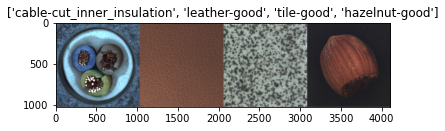

torch.Size([4, 3, 1024, 1024])


In [15]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

train_data, train_loader, valid_loader = create_datasets(batch_size=4)


print('train 데이터셋 크기:', len(train_data))

class_names = train_data.classes
print('클래스:', class_names)

def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.43303847, 0.4034577, 0.39415097])
    std = np.array([0.18344551, 0.17549995, 0.1647388])
    input = std * input + mean
    input = np.clip(input, 0, 1)

    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_loader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
print(inputs.shape)

In [16]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time


device = torch.device('cuda')

In [ ]:
train_png = sorted(glob('train/*.png'))
test_png = sorted(glob('test/*.png'))

In [18]:
pwd

'/home/ubuntu/dacon_data/open'